In [2]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import os
import cv2
import sys
import glob
import time
import json
import copy
import cortex
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# MRI analysis imports
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

# Personal imports
sys.path.append("{}/../../../analysis_code/utils".format(os.getcwd()))
from plot_utils import *
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap, get_rois
from surface_utils import load_surface

In [3]:
# Directories
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'

In [4]:
with open('../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
    
with open('../../figure_settings.json') as f:
    json_s = f.read()
    figure_info = json.loads(json_s)
fig_width = figure_info['fig_width']
    
TR = analysis_info['TR']
TRs = analysis_info['TRs']

In [5]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

# Webgl port
port_num = 25000

In [6]:
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

# pRF time series

## Functions

In [7]:
def gaus_2d_css(gauss_x, gauss_y, gauss_sd, n, screen_side, grain=200):
    """
    Generate 2D Gaussian mesh with CSS model
    
    Parameters
    ----------
    gauss_x : mean x Gaussian parameter in dva (e.g. 1 dva)
    gauss_y : mean y Gaussian parameter in dva (e.g. 1 dva)
    gauss_sd : sd Gaussian parameter in dva (e.g. 1 dva)
    screen_side : mesh screen side (square) in dva (e.g. 20 dva from -10 to 10 dva)
    n : exponent parameter of the CSS model
    grain : grain resolution of the mesh in pixels (default = 200 pixels)
    
    Returns
    -------
    x : linspace x of the mesh
    y : linspace y of the mesh
    z : mesh_z values (to plot)
    
    """
    x = np.linspace(-screen_side/2, screen_side/2, grain)
    y = np.linspace(-screen_side/2, screen_side/2, grain)
    mesh_x, mesh_y = np.meshgrid(x, y)
    
    gauss_z = 1./(2.*np.pi*gauss_sd*gauss_sd) * np.exp(-((mesh_x-gauss_x)**2./(2.*gauss_sd**2.) + (mesh_y-gauss_y)**2./(2.*gauss_sd**2.)))
    
    # Apply the CSS model by raising the Gaussian to the power of n
    gauss_z_css = gauss_z ** n
    
    return x, y, gauss_z_css

In [8]:
def draw_timeseries(bold_data, prf_pred_data, prf_fit_data, vox_data, vox_model, TRs, roi):
    
    # # compute r2 if voxel of model and of data are different
    # if vox_data != vox_model:
    #     r2_val = pingouin.corr(df.data_fs[vox_data], df.pred_fs[vox_model]).iloc[0]['r']**2
    # else:
    #     r2_val = df.r2_fs[vox_model]
    
    
    # General figure settings
    fig_template = plotly_template(template_specs)
    
    # Subplot settings
    rows, cols = 2, 2
    margin_t, margin_b, margin_l, margin_r = 50, 50 ,50 ,50
    fig_ratio = 5
    fig_height = 1080/fig_ratio + (1080/fig_ratio*0.15) + margin_t+margin_b
    fig_width = 1920/fig_ratio + 1920/fig_ratio + margin_l+margin_r
    column_widths,row_heights = [1,1],[0.15,1]
    sb_specs = [[{},{}],[{},{}]]
    hover_data = 'Time: %{x:1.2f} s<br>' + 'z-score: %{y:1.2f}'
    hover_model = 'Time: %{x:1.2f} s<br>' + 'z-score: %{y:1.2f}'

    xaxis_range = [0,250]
    yaxis_range = [-2,3]
    yaxis_dtick = 1
    x_tickvals = np.linspace(0,208,6)*TR
    
    lwd_mot = np.array([ 114*TR,  142*TR, 0.5,  0.5])
    dwd_mot = np.array([ 80*TR, 80*TR, 0.85,  0.15])
    rwd_mot = np.array([ 46*TR,  18*TR, 0.5, 0.5])
    uwd_mot = np.array([176*TR, 176*TR, 0.15, 0.85])
    
    x0_all = np.array([0,16,48,64,96,112,144,160,192])*TR
    x1_all = np.array([16,48,64,96,112,144,160,192,208])*TR
    
    rolling = 3
    data_col = 'rgba(0, 0, 0, 1)'
    model_col = 'rgba(200, 0, 0, 1)'
    subplot_titles = ['<b>{} time series </b> ({})'.format(roi, subject),'','','']
    screen_side = 10*2
    # prf_xrange = [-8.9,8.9]
    # prf_yrange = [-5,5]
    prf_xrange = [-10,10]
    prf_yrange = [-10,10]    
    
    x_par_txt = -10
    y_par_text = 9
    
    # avg to have less points
    bold_data_reshaped = bold_data.reshape(104, 2, -1)
    bold_data_mean = np.mean(bold_data_reshaped, axis=1)
    
    prf_pred_data_reshaped = prf_pred_data.reshape(104, 2, -1)
    prf_pred_data_mean = np.mean(prf_pred_data_reshaped, axis=1)
    # create figure
    fig = make_subplots(rows=rows, cols=cols, specs=sb_specs, print_grid=False, vertical_spacing=0.05, horizontal_spacing=0.05, 
                        column_widths=column_widths, row_heights=row_heights,  subplot_titles=subplot_titles)

    # Timeseries stim
    for x0,x1 in zip(x0_all,x1_all):
        fig.add_shape(type='rect', xref='x', yref='y', x0=x0, y0=0, x1=x1, y1=1, 
                      line_width=2, fillcolor='black', line_color='white')
        
    for [coord_tp] in zip([rwd_mot, dwd_mot, lwd_mot, uwd_mot]):
        fig.add_annotation(ax=coord_tp[0], x=coord_tp[1], ay=coord_tp[2], y=coord_tp[3], 
                           xref='x', yref='y', axref='x',ayref='y',
                           text='', showarrow=True, arrowhead=2, arrowcolor='white')


    # time series data
    fig.append_trace(go.Scatter(x=np.linspace(0,TRs*TR,104), 
                                y=bold_data_mean[:,vox_data],                        
                                name='<i>data<i>',
                                showlegend=False, mode='markers', marker_color=data_col,
                                hovertemplate=hover_data,
                                cliponaxis=False,
                                line_width=0, opacity=1, marker_size=6),row=2, col=1)
    # time series predictions
    fig.append_trace(go.Scatter(x=np.linspace(0,TRs*TR,104), 
                                y=prf_pred_data_mean[:,vox_model],
                                name='<i>model<i>',
                                showlegend=False, mode='lines', line_color=data_col, 
                                hovertemplate=hover_model,
                                cliponaxis=False,
                                line_width=2, opacity=1),row=2, col=1)

    # pRF heatmap
    x,y,z = gaus_2d_css(gauss_x=prf_fit_data[x_idx,vox_model], gauss_y=prf_fit_data[y_idx,vox_model], 
                gauss_sd=prf_fit_data[size_idx,vox_model], n=prf_fit_data[n_idx,vox_model], screen_side=screen_side)
    
    
    fig.append_trace(go.Heatmap(x=x, y=y, z=z,colorscale='viridis', showscale=False, hoverinfo='none'),row=2,col=2)

#     fig.add_annotation(x=prf_fit_data[x_idx,vox_model], ax=prf_fit_data[x_idx,vox_model], y=prf_yrange[0], ay=prf_yrange[0]-0.5,
#                        xref='x4', yref='y4', axref='x4',ayref='y4', yanchor="top", showarrow=True,
#                        text='<i>pRFx</i> = {:1.2g}°'.format(prf_fit_data[x_idx,vox_model]), arrowhead=2, arrowwidth=2.5)

#     fig.add_annotation(x=prf_xrange[1], ax=prf_xrange[1]+0.5, y=prf_fit_data[y_idx,vox_model], ay=prf_fit_data[y_idx,vox_model],
#                        xref='x4', yref='y4', axref='x4',ayref='y4', yanchor="top", showarrow=True, 
#                        text='<i>pRFy</i> = {:1.2g}°'.format(prf_fit_data[y_idx,vox_model]), textangle=-90, arrowhead=2, arrowwidth=2.5)
    
#     fig.add_shape(type='line', xref='x4', yref='y4', x0=prf_xrange[0], x1=prf_xrange[1], y0=prf_fit_data[y_idx,vox_model], y1=prf_fit_data[y_idx,vox_model], 
#                       line_width=2, line_color='white', line_dash='dot')
    
#     fig.add_shape(type='line', xref='x4', yref='y4', x0=prf_fit_data[x_idx,vox_model], x1=prf_fit_data[x_idx,vox_model], y0=prf_yrange[0], y1=prf_yrange[1], 
#                       line_width=2, line_color='white', line_dash='dot')     
    
#     fig.add_annotation(x=x_par_txt, y=y_par_text, xref='x4', yref='y4', xanchor="left", font_color='white', showarrow=False,
#                        text='<i>pRF loo R<sup>2</sup></i> = {:1.2g}'.format(prf_fit_data[r2_idx,vox_model]))
    
#     fig.add_annotation(x=x_par_txt, y=y_par_text-1.5, xref='x4', yref='y4', xanchor="left", font_color='white', showarrow=False,
#                        text='<i>pRF size</i> = {:1.2g}°'.format(prf_fit_data[size_idx,vox_model]))
    
#     fig.add_annotation(x=x_par_txt, y=y_par_text-3, xref='x4', yref='y4',  xanchor="left", font_color='white', showarrow=False, 
#                        text='<i>pRF ecc</i> = {:1.2g}°'.format(prf_fit_data[ecc_idx,vox_model]))
    
#     fig.add_annotation(x=x_par_txt, y=y_par_text-4.5, xref='x4', yref='y4',  xanchor="left", font_color='white', showarrow=False, 
#                        text='<i>pRF angle</i> = {:3.0f}°'.format(np.angle(prf_fit_data[x_idx,vox_model] + 1j * prf_fit_data[y_idx,vox_model],deg=True)))

    # set axis
    for row in np.arange(rows):
        for col in np.arange(cols):
            fig.update_xaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)
            fig.update_yaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)
            
    fig.update_xaxes(scaleanchor="y4", scaleratio=1, row=2, col=2)
    fig.update_yaxes(scaleanchor="x4", scaleratio=1, row=2, col=2)
    fig.layout.update(xaxis_range=xaxis_range, xaxis_title='', 
                      xaxis_visible=False, yaxis_visible=False,
                      yaxis_range=[0,1], yaxis_title='',
                      xaxis4_range=prf_xrange, xaxis4_title='', 
                      yaxis4_range=prf_yrange, yaxis4_title='', 
                      xaxis4_visible=False, yaxis4_visible=False,
                      xaxis3_tickvals=x_tickvals, xaxis3_ticktext=np.round(x_tickvals),
                      xaxis3_range=xaxis_range, xaxis3_title='Time (seconds)',
                      yaxis3_range=yaxis_range, yaxis3_title='z-score',yaxis3_dtick=yaxis_dtick,
                      template=fig_template, width=fig_width, height=fig_height, 
                      margin_l=margin_l+10, margin_r=margin_r-10, margin_t=margin_t-20, margin_b=margin_b+20,
                      legend_yanchor='top', legend_y=0.85, legend_xanchor='left', 
                      legend_x=0.02, legend_bgcolor='rgba(255,255,255,0)')

    return fig

## Plots

In [9]:
subject = 'sub-11'
format_ = '170k'
extension = 'dtseries.nii'
task = 'pRF'

In [10]:
bold_dir = '{}/{}/derivatives/pp_data/{}/{}/func/fmriprep_dct_loo_avg'.format(main_dir, project_dir,subject,format_)
bold_fn = '{}/{}_task-pRF_fmriprep_dct_avg_loo-1_bold.{}'.format(bold_dir, subject, extension)
bold_img, bold_data = load_surface(fn = bold_fn)

In [11]:
prf_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/fit/'.format(main_dir, project_dir,subject,format_)
prf_pred_fn = '{}/{}_task-pRF_fmriprep_dct_avg_loo-1_prf-pred_css.{}'.format(prf_dir, subject, extension)
prf_pred_img, prf_pred_data = load_surface(fn = prf_pred_fn)

In [12]:
ecc_idx, size_idx, x_idx, y_idx, n_idx, r2_idx = 1,4,7,8,11,12

prf_deriv_dir = '{}/{}/derivatives/pp_data/{}/{}/prf/prf_derivatives'.format(main_dir, project_dir,subject,format_)
prf_fit_fn = '{}/{}_task-pRF_fmriprep_dct_avg_loo-1_prf-deriv_css.{}'.format(prf_deriv_dir, subject, extension)
prf_fit_img, prf_fit_data = load_surface(fn = prf_fit_fn)

In [13]:
# find best loo r2
prf_loo_r2_idx = -1


# Find best R2 in frontal and parietal eyes fields
# load rois mask
rois_dict_mmp_group = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='170k')

# Defind masks
frontal_mask = rois_dict_mmp_group['iPCS'] | rois_dict_mmp_group['sPCS'] | rois_dict_mmp_group['mPCS']
parietal_mask = rois_dict_mmp_group['iIPS'] | rois_dict_mmp_group['sIPS']
parietal_frontal_mask = rois_dict_mmp_group['iPCS'] | rois_dict_mmp_group['sPCS'] | rois_dict_mmp_group['mPCS'] | rois_dict_mmp_group['iIPS'] | rois_dict_mmp_group['sIPS']
parietal_frontal_mask = rois_dict_mmp_group['V2']

In [14]:
# Find the R2
max_indices  = np.flatnonzero(parietal_frontal_mask)[np.nanargmax(prf_fit_data[prf_loo_r2_idx, parietal_frontal_mask]**2)]

# Find the correponding area
best_r2_vertex_roi = [key for key, array in rois_dict_mmp_group.items() if array[max_indices]]

In [15]:
prf_fit_data[prf_loo_r2_idx,max_indices]

0.7830700874328613

In [16]:
prf_pred_data.shape

(208, 170494)

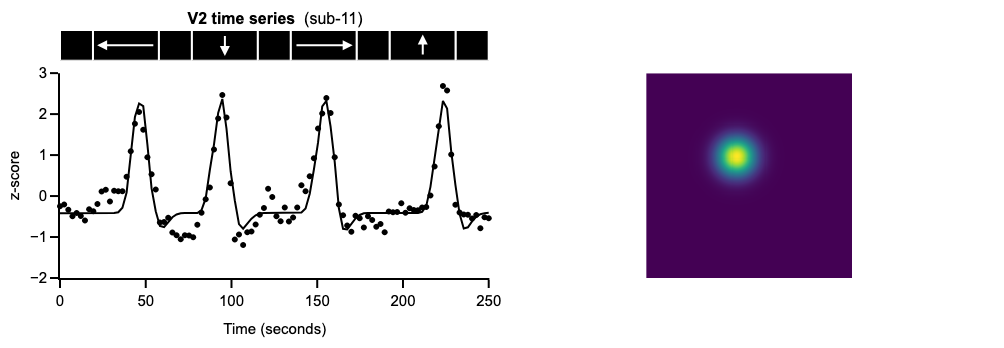

In [20]:
vertex_to_plot = max_indices 
fig = draw_timeseries(bold_data=bold_data, prf_pred_data=prf_pred_data,prf_fit_data=prf_fit_data, vox_data=vertex_to_plot, vox_model=vertex_to_plot, TRs=TRs, roi=best_r2_vertex_roi[0])
time_series_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/time_series/'
# fig.write_image('{}/pRF_time_series_{}_{}.pdf'.format(time_series_dir, task, 'final_parameters'))
fig.show()

### fake predictions

In [17]:
input_vd = '{}/{}/derivatives/vdm/vdm_pRF_50_50.npy'.format(main_dir, project_dir)

In [18]:
# load VDM 
screen_size_cm = analysis_info['screen_size_cm']
screen_distance_cm = analysis_info['screen_distance_cm']
# load visual design
vdm = np.load(input_vd)

# determine visual design
stimulus = PRFStimulus2D(screen_size_cm=screen_size_cm[1], 
                         screen_distance_cm=screen_distance_cm,
                         design_matrix=vdm, 
                         TR=TR)

In [111]:
rsq_idx = 0; ecc_idx = 1; polar_real_idx = 2; polar_imag_idx = 3; size_idx = 4; amplitude_idx = 5; baseline_idx = 6; x_idx = 7; y_idx = 8; hrf_1_idx = 9; hrf_2_idx = 10; n_idx = 11; r2_idx = 12

# arrange data
bold_data_vert = bold_data[:,vertex_to_plot].reshape(-1,1)
css_pred_mat_vert = np.zeros_like(bold_data_vert).T 
prf_fit_data_vert = prf_fit_data[:, vertex_to_plot].copy().reshape(-1,1).T 


In [112]:
# choose the parameter to modify
prf_fit_data_vert[0, x_idx] = prf_fit_data_vert[0, x_idx] + 5
prf_fit_data_vert[0, y_idx] = prf_fit_data_vert[0, y_idx] - 5
prf_fit_data_vert[0, size_idx] = prf_fit_data_vert[0, size_idx] + 0.6
prf_fit_data_vert[0, n_idx] = prf_fit_data_vert[0, n_idx] - 0.1

In [113]:
# define css model
css_model = CSS_Iso2DGaussianModel(stimulus=stimulus)
# Make a prediction
css_pred_mat_vert[0,:] = css_model.return_prediction(mu_x=prf_fit_data_vert[0][x_idx],
                                                  mu_y=prf_fit_data_vert[0][y_idx], 
                                                  size=prf_fit_data_vert[0][size_idx], 
                                                  beta=prf_fit_data_vert[0][amplitude_idx], 
                                                  baseline=prf_fit_data_vert[0][baseline_idx],
                                                  n=prf_fit_data_vert[0][n_idx],
                                                  hrf_1=prf_fit_data_vert[0][hrf_1_idx],
                                                  hrf_2=prf_fit_data_vert[0][hrf_2_idx])
css_pred_mat_vert = css_pred_mat_vert.T

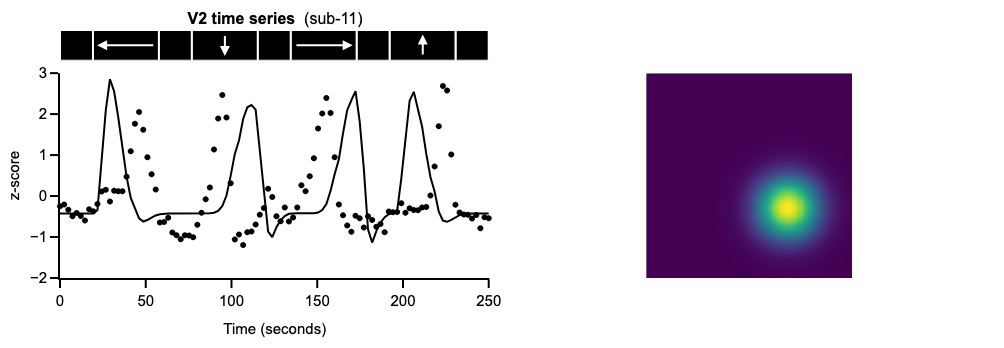

In [114]:
vertex_to_plot_2 = 0
fig = draw_timeseries(bold_data=bold_data_vert, 
                      prf_pred_data=css_pred_mat_vert, 
                      prf_fit_data=prf_fit_data_vert.T, 
                      vox_data=vertex_to_plot_2, 
                      vox_model=vertex_to_plot_2, 
                      TRs=TRs, 
                      roi=best_r2_vertex_roi[0])
time_series_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/time_series/'

fig.write_image('{}/pRF_time_series_change_x_y_size.pdf'.format(time_series_dir))
# fig.write_image('{}/pRF_time_series_change_y_size.pdf'.format(time_series_dir))
# fig.write_image('{}/pRF_time_series_change_size.pdf'.format(time_series_dir))


fig.show()

In [112]:
prf_fit_data_vert

array([[ 0.87246317,  2.2481277 , -0.54193002,  0.84042358,  1.2221415 ,
         0.15994312, -0.4406397 , -1.21832788,  1.8893795 ,  3.50782728,
        -0.80924731,  0.8857429 ,  0.78307009]])

In [100]:
bold_data_vert

array([[-0.42428342],
       [-0.07376765],
       [-0.39748329],
       [-0.01366619],
       [-0.37681603],
       [-0.29474318],
       [-0.20289311],
       [-0.77748102],
       [-0.38752532],
       [-0.4413254 ],
       [-0.46776623],
       [-0.50474417],
       [-0.46703887],
       [-0.72045922],
       [-0.19491856],
       [-0.45013994],
       [-0.41051829],
       [-0.32697982],
       [-0.2793934 ],
       [-0.11333799],
       [ 0.30747199],
       [-0.08186825],
       [ 0.4313904 ],
       [-0.12305041],
       [-0.08992113],
       [-0.17908198],
       [-0.00458725],
       [ 0.26383251],
       [ 0.04528119],
       [ 0.18817401],
       [ 0.13309754],
       [ 0.10161857],
       [ 0.1847699 ],
       [ 0.75467604],
       [ 0.95134664],
       [ 1.23921466],
       [ 1.60822713],
       [ 1.92084324],
       [ 1.83040786],
       [ 2.26732516],
       [ 1.71237803],
       [ 1.52058554],
       [ 1.08887374],
       [ 0.8062799 ],
       [ 0.51598084],
       [ 0

# GLM time series

## Function

In [65]:
def draw_timeseries2(bold_data, model_prediction, vox_data, vox_model, TRs, roi):
    
    # General figure settings
    fig_template = plotly_template(template_specs)
    
    # Subplot settings
    rows, cols = 2, 2
    margin_t, margin_b, margin_l, margin_r = 50, 50, 50, 50
    fig_ratio = 5
    fig_height = 1080/fig_ratio + (1080/fig_ratio*0.15) + margin_t + margin_b
    fig_width = 1920/fig_ratio + 1920/fig_ratio + margin_l + margin_r
    column_widths, row_heights = [1, 1], [0.15, 1]
    sb_specs = [[{}, {}], [{}, {}]]
    hover_data = 'Time: %{x:1.2f} s<br>' + 'z-score: %{y:1.2f}'
    hover_model = 'Time: %{x:1.2f} s<br>' + 'z-score: %{y:1.2f}'

    xaxis_range = [0, 250]
    yaxis_range = [-2, 3]
    yaxis_dtick = 1
    x_tickvals = np.linspace(0, 208, 6) * TR

    model_xrange = [-10, 10]
    model_yrange = [-10, 10]    

    rolling = 3
    data_col = 'rgba(0, 0, 0, 1)'
    model_col = 'rgba(200, 0, 0, 1)'
    subplot_titles = ['<b>{} time series </b> ({})'.format(roi, subject), '', '', '']

    # avg to have less points
    bold_data_reshaped = bold_data.reshape(104, 2, -1)
    bold_data_mean = np.mean(bold_data_reshaped, axis=1)

    model_pred_data_reshaped = model_prediction.reshape(104, 2, -1)
    model_pred_data_mean = np.mean(model_pred_data_reshaped, axis=1)

    # create figure
    fig = make_subplots(
        rows=rows, cols=cols, specs=sb_specs, print_grid=False,
        vertical_spacing=0.05, horizontal_spacing=0.05,
        column_widths=column_widths, row_heights=row_heights,
        subplot_titles=subplot_titles
    )

    # time series data
    fig.append_trace(go.Scatter(
        x=np.linspace(0, TRs*TR, 104),
        y=bold_data_mean[:, vox_data],
        name='<i>data<i>',
        showlegend=False, mode='markers', marker_color=data_col,
        hovertemplate=hover_data,
        cliponaxis=False,
        line_width=0, opacity=1, marker_size=6
    ), row=2, col=1)

    # time series predictions
    fig.append_trace(go.Scatter(
        x=np.linspace(0, TRs*TR, 104),
        y=model_pred_data_mean[:, vox_model],
        name='<i>model<i>',
        showlegend=False, mode='lines', line_color=data_col,
        hovertemplate=hover_model,
        cliponaxis=False,
        line_width=2, opacity=1
    ), row=2, col=1)

    # set axis
    for row in np.arange(rows):
        for col in np.arange(cols):
            fig.update_xaxes(
                visible=True, ticklen=8, linewidth=template_specs['axes_width'],
                row=row+1, col=col+1
            )
            fig.update_yaxes(
                visible=True, ticklen=8, linewidth=template_specs['axes_width'],
                row=row+1, col=col+1
            )
            
    fig.update_xaxes(scaleanchor="y4", scaleratio=1, row=2, col=2)
    fig.update_yaxes(scaleanchor="x4", scaleratio=1, row=2, col=2)
    fig.layout.update(
        xaxis_range=xaxis_range, xaxis_title='', 
        xaxis_visible=False, yaxis_visible=False,
        yaxis_range=[0, 1], yaxis_title='',
        xaxis4_range=model_xrange, xaxis4_title='', 
        yaxis4_range=model_yrange, yaxis4_title='', 
        xaxis4_visible=False, yaxis4_visible=False,
        xaxis3_tickvals=x_tickvals, xaxis3_ticktext=np.round(x_tickvals),
        xaxis3_range=xaxis_range, xaxis3_title='Time (seconds)',
        yaxis3_range=yaxis_range, yaxis3_title='z-score', yaxis3_dtick=yaxis_dtick,
        template=fig_template, width=fig_width, height=fig_height,
        margin_l=margin_l+10, margin_r=margin_r-10, margin_t=margin_t-20, margin_b=margin_b+20,
        legend_yanchor='top', legend_y=0.85, legend_xanchor='left',
        legend_x=0.02, legend_bgcolor='rgba(255,255,255,0)'
    )

    return fig

## Load data

In [76]:
# Settings
subject = 'sub-11'
format_ = '170k'
extension = 'dtseries.nii'

task = 'PurLoc'
# task = 'SacLoc'


In [77]:
bold_dir = '{}/{}/derivatives/pp_data/{}/{}/func/fmriprep_dct_loo_avg'.format(main_dir, project_dir,subject,format_)
bold_glm_dir = '{}/{}/derivatives/pp_data/{}/{}/func/fmriprep_dct_loo_avg'.format(main_dir, project_dir, subject, format_)
bold_glm_fn = '{}/{}_task-{}_fmriprep_dct_avg_loo-1_bold.{}'.format(bold_dir, subject, task, extension)
bold_glm_img,bold_glm_data = load_surface(fn = bold_glm_fn)

In [78]:
glm_dir ='{}/{}/derivatives/pp_data/{}/{}/glm/glm_fit/'.format(main_dir, project_dir,subject,format_)
glm_pred_fn = '{}/{}_task-{}_fmriprep_dct_avg_loo-1_glm-pred.{}'.format(glm_dir, subject, task, extension)
glm_pred_img, glm_pred_data = load_surface(fn = glm_pred_fn)

In [79]:
glm_stats_dir ='{}/{}/derivatives/pp_data/{}/{}/glm/glm_derivatives/'.format(main_dir, project_dir,subject,format_)
glm_fit_fn = '{}/{}_task-{}_fmriprep_dct_avg_loo-1_glm-stats.{}'.format(glm_stats_dir, subject, task, extension)
glm_fit_img, glm_fit_data = load_surface(fn = glm_fit_fn)
slope_idx, intercept_idx, rvalue_idx, pvalue_idx, stderr_idx  = 0,1,2,3,4

In [80]:
session = 'ses-02'
event_dir = '{}/{}/{}/{}/func/'.format(main_dir,project_dir,subject,session)
event_file = glob.glob("{}/{}_{}_task-{}_run-*_events.tsv".format(event_dir,subject,session,task))
events = pd.read_table(event_file[0])

In [81]:
if task == 'PurLoc': 
    idx = 2
    task_name = 'Pursuit'
    color = '#E377C2'
    task_periode = np.where(events['trial_type'] == idx, 1, np.nan)
elif task == 'PurVELoc': 
    idx = 2
    task_name = 'Pursuit'
    color = '#E377C2'
    task_periode = np.where(events['eyemov_vis_end'] == idx, 1, np.nan)
elif task == 'SacLoc': 
    idx = 1
    task_name = 'Saccad'
    color = '#8C564B'
    task_periode = np.where(events['trial_type'] == idx, 1, np.nan)
elif task == 'SacVELoc': 
    idx = 2
    task_name = 'Saccade'
    color = '#8C564B'
    task_periode = np.where(events['eyemov_vis_end'] == idx, 1, np.nan)

In [82]:
# Find best R2 in frintal and parietal eyes fields
# load rois mask
rois_dict_mmp_group = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='170k')

# Defind masks
frontal_mask = rois_dict_mmp_group['iPCS'] | rois_dict_mmp_group['sPCS'] | rois_dict_mmp_group['mPCS']
parietal_mask = rois_dict_mmp_group['iIPS'] | rois_dict_mmp_group['sIPS']
parietal_frontal_mask = rois_dict_mmp_group['iPCS'] | rois_dict_mmp_group['sPCS'] | rois_dict_mmp_group['mPCS'] | rois_dict_mmp_group['iIPS'] | rois_dict_mmp_group['sIPS']

# Find the R2
max_indices  = np.flatnonzero(parietal_frontal_mask)[np.nanargmax(glm_fit_data[rvalue_idx, parietal_frontal_mask]**2)]

# Find the correponding area
best_r2_vertex_roi = [key for key, array in rois_dict_mmp_group.items() if array[max_indices]]



In [83]:
glm_fit_data[rvalue_idx,max_indices]**2

0.6120024220997635

## Plot

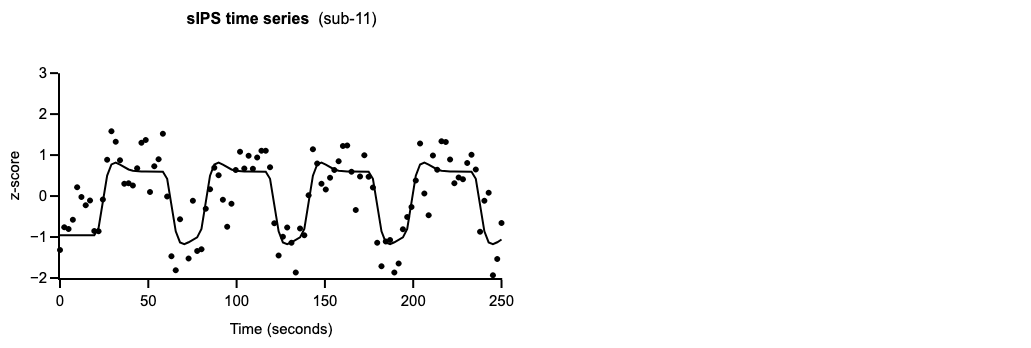

In [84]:
fig = draw_timeseries2(bold_data=bold_glm_data[:,:], model_prediction=glm_pred_data[:,:], vox_data=max_indices, vox_model=max_indices, TRs=TRs, roi=best_r2_vertex_roi[0])

time_series_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/time_series/'
fig.write_image('{}/glm_time_series_{}.pdf'.format(time_series_dir, task))
fig.show()

# Brouillon

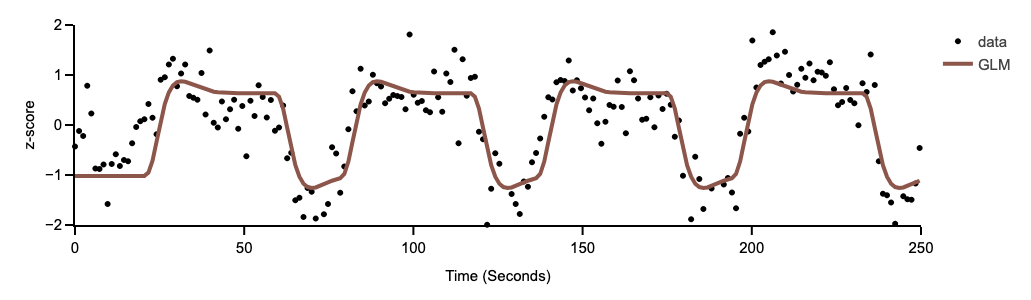

In [148]:
num_vert = max_indices
num_vert_r2 = num_vert

fig = go.Figure()

# data time series
fig.add_trace(go.Scatter(x=np.linspace(0,TRs*TR,glm_pred_data[:,num_vert_r2].shape[0]), 
                         y=bold_glm_data[:,num_vert], 
                         name='data', 
                         mode='markers', 
                         line=dict(color='black'),
                         cliponaxis=False
                         ))

# plot GLM prediction
fig.add_trace(go.Scatter(x=np.linspace(0,TRs*TR,glm_pred_data[:,num_vert_r2].shape[0]), 
                         y=glm_pred_data[:,num_vert_r2], 
                         line=dict(color=color ,width=4), 
                         name='GLM',
                         cliponaxis=False
                        ))

# R2 for glm
fig.add_annotation(text='R<sup>2</sup>={:1.2f}'.format(glm_fit_data[rvalue_idx,num_vert_r2]),  
                    x=198,  
                    y=4,
                    showarrow=False
                   )

# Update axes
fig.update_xaxes(showline=True, 
                 title='Time (Seconds)', 
                 range=[0,250]
                )

fig.update_yaxes(showline=True, 
                 title='z-score', 
                 range=[-2,2] 
                )


fig.update_layout(template=fig_template, 
                  showlegend= True, 
                  height=300, 
                  width=500, 
                  margin_l=75, 
                  margin_r=25, 
                  margin_t=25, 
                  margin_b=75
                 )


time_series_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/time_series/'
fig.write_image('{}/glm_time_series_{}.pdf'.format(time_series_dir, task))

fig.show()